<H1> Filtering the effect of general topological signal by scPrisma</h1>

In this tutorial, we will demonstrate how to filter out the variance which is explained by a covarainace matrix which is provided by the user (in contrast to the examples in scPrisma manuscript, which were focused on cyclic topology).

Few design principles for designing theoretical covaraince matrix:
1. scPrisma was designed for continoius topologies, and especially circular topology (were we have closed formula for the spectrum). The ideal design way is to create similiar "toy model" (has been done for the circular topology in the "Methods" section), find its appropriate covariance matrix and perform numerical eigen decomposition. Note: as been writen in the discussion, for complex topologies (other than cyclic) the reconstruction task would be very challenging.
2. The covariance matrix should to be symmetric PSD matrix (for enable numerical eigendecomposition) with ones over the diagonal of the matrix.
3. In some scenarios, it is recommended to eliminate the dominant eigenvector, particularly when it is an 'offset' eigenvector, as in the case of a cyclic covariance matrix, where the lead eigenvector is a constant eigenvector.

We will utilize certain functions to achieve this without requiring installation of scPrisma. As a practical example, we will apply batch correction to four datasets of pancreatic cells (obtained from the <a href="https://academic.oup.com/bioinformatics/article/36/3/964/5545955">BBKNN</a> paper).
It is recommended to follow the pre-processing and parameter selection procedures outlined in the scPrisma manuscript in order to optimize the results of the analysis.



In [1]:


import scanpy as sc
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import normalize
import torch
from sklearn.preprocessing import MultiLabelBinarizer

def get_theoretic_eigen(cov, n_values=None):
    """
    Calculate the theoretical eigenvalues and eigenvectors of a given covariance matrix.
    
    Parameters
    ----------
    cov : ndarray
        The covariance matrix to calculate eigenvalues and eigenvectors for.
    n_values : int, optional
        The number of eigenvalues and eigenvectors to return. If not provided, all eigenvalues and eigenvectors are returned.
    
    Returns
    -------
    ndarray
        The eigenvectors of the covariance matrix.
    """
    if n_values==None:
        n_values= cov.shape[0]
    eig_vals, eig_vecs = np.linalg.eigh(cov)
    idx = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    eig_vals = eig_vals[:n_values]
    eig_vecs = eig_vecs[:,:n_values]
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)
    first_non_positive = np.argmax(eig_vals<=1e-10)
    if first_non_positive!=0:
        eig_vals = eig_vals[:first_non_positive]
        eig_vecs = eig_vecs[:,:first_non_positive]
    for i in range(eig_vals.size):
            eig_vecs[:, i] *= np.sqrt(eig_vals[i])
    return eig_vecs

def filter_general_covariance(adata, cov, regu=0, epsilon=0.1, iterNum=100, regu_norm='L1', device='cpu'):
    """
    Filters `adata` based on a discrete label by running gradient descent with L1 regularization.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object to filter.
    cov : ndarray
        The covariance matrix to calculate eigenvalues and eigenvectors for.
    regu : float
        Regularization coefficient.
    epsilon : float, optional
        Step size (learning rate).
    iterNum : int, optional
        Number of iterations to run gradient descent.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    device : str, optional
        Device to use for computations, either 'cpu' or 'cuda'.
    
    Returns
    -------
    filtered_X : torch.Tensor
        Filtered version of `adata.X`
    """
    bdata = adata.copy()
    V =  torch.tensor(np.array(get_theoretic_eigen(cov)).astype(float), device=device)
    A = np.array((adata.X).copy())
    A = normalize(A, axis=1, norm='l2')
    A = torch.tensor(A.astype(float)   , device=device)
    F = torch.tensor(np.ones(A.shape).astype(float) , device=device)
    F = gradient_descent_full(A, F.type(torch.float), V=V, regu=0, epsilon=0.1, iterNum=100)
    del A, V
    F = F.cpu().detach().numpy()
    bdata.X = bdata.X * F
    del F
    return bdata


import torch

def gradient_descent_full(A, F, V, regu, epsilon=0.1, iterNum=100, regu_norm='L1'):
    """
    Runs gradient descent to find the optimal filtering matrix `F` for the given gene expression matrix `A`,
    discrete labels `V`, and regularization coefficient `regu`.
    
    Parameters
    ----------
    A : torch.Tensor
        Gene expression matrix.
    F : torch.Tensor
        Initial filtering matrix.
    V : torch.Tensor
        One-hot encoded discrete label matrix.
    regu : float
        Regularization coefficient.
    epsilon : float, optional
        Step size (learning rate).
    iterNum : int, optional
        Number of iterations to run gradient descent.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    
    Returns
    -------
    F : torch.Tensor
        Optimal filtering matrix.
    """
    j = 0
    epsilon_t = epsilon
    while j < iterNum:
        if j % 100 == 1:
            print("Iteration number: " + str(j))
        epsilon_t *= 0.995
        grad = grad_filtering_torch(A=A, B=F, V=V, regu=regu, regu_norm=regu_norm)
        F = F - epsilon_t * grad
        F = torch.clamp(F, 0, 1)
        j += 1
    del grad
    return F


def grad_filtering_torch(A, B, V, regu, regu_norm='L1'):
    """
    Calculates the gradient of `B` according to `A` and the discrete labels in `V`.
    
    Parameters
    ----------
    A : torch.Tensor
        Gene expression matrix.
    B : torch.Tensor
        Filtering matrix.
    V : torch.Tensor
        One-hot encoded discrete label matrix.
    regu : float
        Regularization coefficient.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    Returns
    -------
    gradient : torch.Tensor
        Gradient of `B` with respect to `A` and `V`.
    """
    if regu_norm == 'L1':
        T_0 = (A * B)
        gradient = ((2 * (((V).matmul(V.t())).matmul(T_0) * A)) - ((regu) * torch.sign(B)))
    else:
        T_0 = (A * B)
        t_1 = torch.norm((A * B), p='fro')
        gradient = ((2 * (((V).matmul(V.t())).matmul(T_0) * A)) - ((regu / t_1) * B))
    return  gradient


In [2]:
if torch.cuda.is_available(): 
 device = "cuda:0" 
else: 
 device = "cpu" 

In [3]:
device

'cuda:0'

In [4]:
adata_all = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
adata_all

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Designing covariance matrix 

In [5]:
cov = np.zeros((adata_all.shape[0],adata_all.shape[0]))
for i , j in enumerate(adata_all.obs["batch"]):
        cov[i,:]+=np.array(adata_all.obs["batch"]==j,dtype=int)


In [6]:
adata_corrrected = adata_all.copy()

Iteration number: 1


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


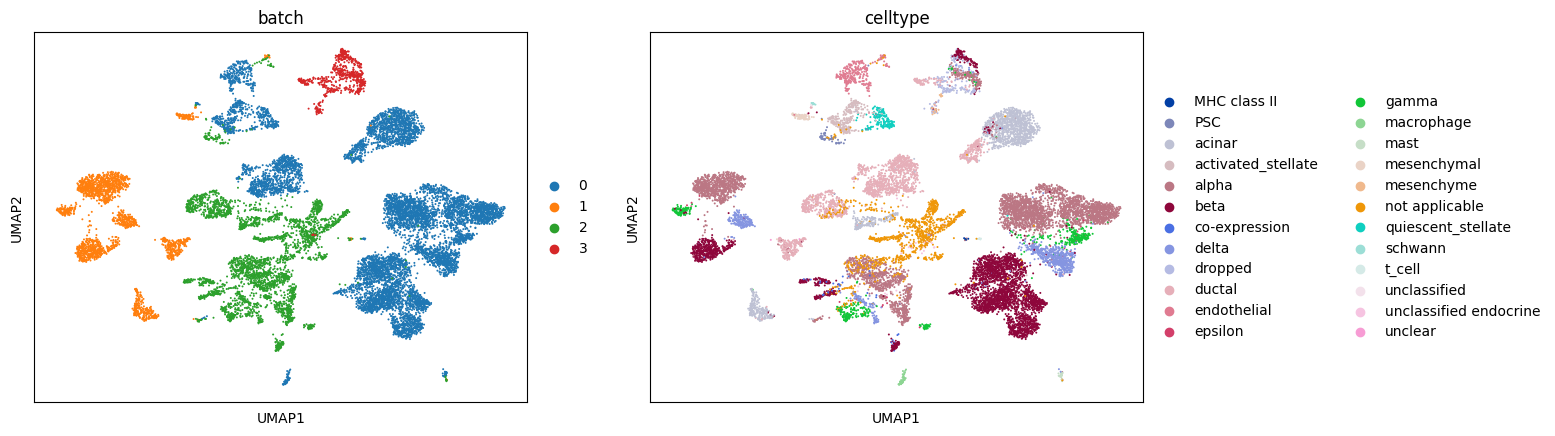

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


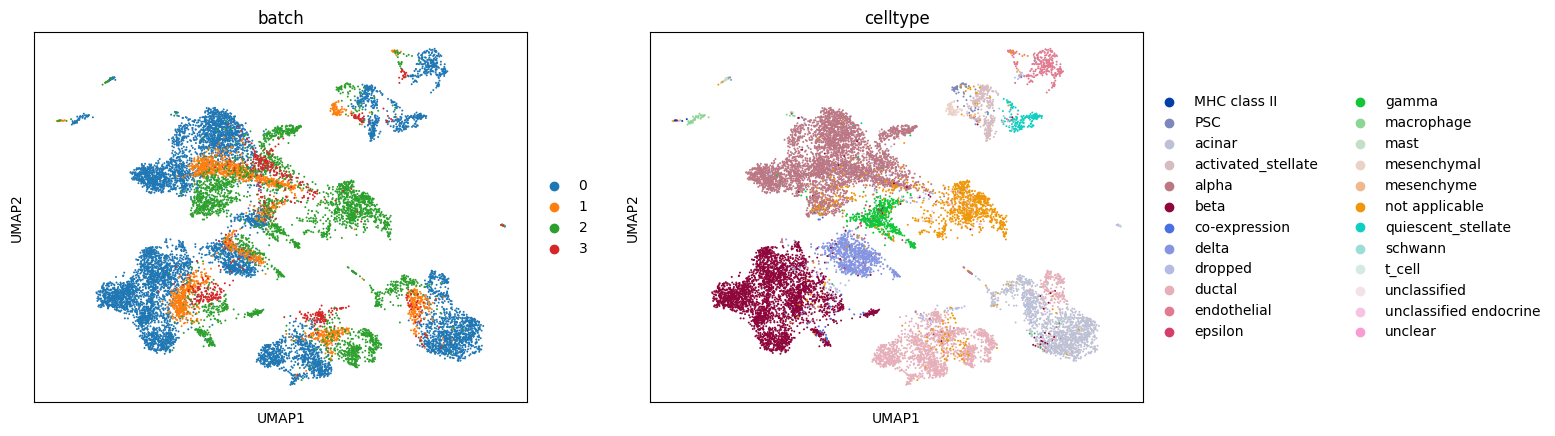

In [7]:
adata_corrrected = filter_general_covariance(adata_corrrected,cov, regu=0, device=device)
sc.pp.pca(adata_all)
sc.pp.pca(adata_corrrected)
sc.pp.neighbors(adata_all)
sc.pp.neighbors(adata_corrrected)
sc.tl.umap(adata_all)
sc.tl.umap(adata_corrrected)
sc.pl.umap(adata_all, color=['batch','celltype'])
sc.pl.umap(adata_corrrected, color=['batch','celltype'])


In [8]:
from sklearn import metrics

In [9]:
print("silhouette_score between different batches:")
print("Raw data:")
print(metrics.silhouette_score(adata_all.obsm['X_pca'],adata_all.obs['batch']))
print("Corrected data:")
print(metrics.silhouette_score(adata_corrrected.obsm['X_pca'],adata_corrrected.obs['batch']))
print("silhouette_score between different celltypes:")
print("Raw data:")
print(metrics.silhouette_score(adata_all.obsm['X_pca'],adata_all.obs['celltype']))
print("Corrected data:")
print(metrics.silhouette_score(adata_corrrected.obsm['X_pca'],adata_corrrected.obs['celltype']))


silhouette_score between different batches:
Raw data:
0.21305905
Corrected data:
-0.10195794
silhouette_score between different celltypes:
Raw data:
0.047459796
Corrected data:
0.091102235
